<a href="https://colab.research.google.com/github/Hanbin-git/DNA/blob/main/data_feature_create.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 압축풀기
import zipfile
import os

zip_path = "/open.zip"
extract_dir = "/content/open"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ 압축 해제 완료!")
print("압축 풀린 파일 목록:", os.listdir(extract_dir))


✅ 압축 해제 완료!
압축 풀린 파일 목록: ['test.csv', 'sample_submission.csv']


In [2]:
# 데이터 불러오기
import pandas as pd

data_dir = "/content/open"

test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))
sub_df  = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))

print("✅ test_df:", test_df.shape)
print("✅ sub_df:", sub_df.shape)
test_df.head()


✅ test_df: (13711, 2)
✅ sub_df: (13711, 769)


,ID,seq
0,TEST_000000,ATCATTTTTATTTTTTAGTTTTATGAGACGCTGCCTTGCTATGTCA...
1,TEST_000001,CGACGTCCCCGTAGCGGCCGAAGTCGAGGGGCAGCAGGCGATCGTG...
2,TEST_000002,GGTAGTAAGAAGGAAAATGACAGCATGGAAGCAGCAATACCAGTAA...
3,TEST_000003,CAGCGCATATACTCAGGGCCATGGTGGGTACTGTTCCCATGGCCAG...
4,TEST_000004,TTCATAATTGCTATCAGTCTATGGGCTAATATTTTATACATCAATG...


In [3]:
# 1) 기본 정보
print("shape:", test_df.shape)
print("\ninfo():")
print(test_df.info())

# 2) 결측치
print("\nnull count:")
print(test_df.isnull().sum())

# 3) ID 중복 여부
print("\n중복 ID 개수:", test_df["ID"].duplicated().sum())

# 4) 완전히 동일한 seq 중복 여부
print("완전히 동일한 seq 중복 개수:",
      test_df["seq"].duplicated().sum())


shape: (13711, 2)

info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13711 entries, 0 to 13710
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      13711 non-null  object
 1   seq     13711 non-null  object
dtypes: object(2)
memory usage: 214.4+ KB
None

null count:
ID     0
seq    0
dtype: int64

중복 ID 개수: 0
완전히 동일한 seq 중복 개수: 0


In [ ]:
# 결측치 없음
# 각 샘플이 고유
# 동일한 염기서열이 없음-> 변이 중심 데이터로 설계된 것 같음.

In [4]:
# sequence 길이 분포 확인
# 길이 컬럼 추가
test_df["seq_len"] = test_df["seq"].str.len()

print("최소 길이:", test_df["seq_len"].min())
print("최대 길이:", test_df["seq_len"].max())
print("평균 길이:", test_df["seq_len"].mean())

test_df["seq_len"].describe()


최소 길이: 1024
최대 길이: 1024
평균 길이: 1024.0


,seq_len
count,13711.0
mean,1024.0
std,0.0
min,1024.0
25%,1024.0
50%,1024.0
75%,1024.0
max,1024.0


In [ ]:
# 최소길이, 최대길이가 전부 동일함.
# 모델 고정해도 패딩이 필요없을듯
# 배치마다 길이 동일해서 GPU 패딩 overhead 문제는 없을 것임
# 길이가 동일하므로 cosine distance 계산 시에 bias 문제는 없음
# 변이 위치가 중요할 듯(모델이 변이 위치를 민감하게 구분할 수 있어야 함)

In [5]:
# 염기서열 구성 비율 확인
from collections import Counter

def base_count(seq):
    return Counter(seq)

# 전체 카운트
total_counter = Counter()
for s in test_df["seq"]:
    total_counter.update(s)

print("전체 염기 카운트:", total_counter)

# 비율 계산
total_bases = sum(total_counter.values())
base_freq = {b: total_counter[b] / total_bases for b in ["A","C","G","T"]}
print("전체 염기 비율:", base_freq)


전체 염기 카운트: Counter({'T': 3688802, 'A': 3665493, 'G': 3342991, 'C': 3342778})
전체 염기 비율: {'A': 0.26107380991995477, 'C': 0.23808851583582524, 'G': 0.23810368670684123, 'T': 0.26273398753737875}


In [6]:
# 이상한 염기서열도 있는지 확인
valid = set("ACGT")
weird_counter = Counter()

for s in test_df["seq"]:
    weird_counter.update([ch for ch in s if ch not in valid])

print("ACGT 이외의 문자 카운트:", weird_counter)


ACGT 이외의 문자 카운트: Counter()


In [ ]:
# 데이터 정제 수준 높음( 이상한 염기서열은 없음)
# 특정 염기 편향은 적은 편임

In [7]:
# GC content 분포 확인
def gc_content(seq):
    seq = seq.upper()
    g = seq.count("G")
    c = seq.count("C")
    length = len(seq)
    return (g + c) / length if length > 0 else 0.0

test_df["gc"] = test_df["seq"].apply(gc_content)

print(test_df["gc"].describe())


count    13711.000000
mean         0.476192
std          0.095096
min          0.124023
25%          0.405273
50%          0.468750
75%          0.537109
max          0.816406
Name: gc, dtype: float64


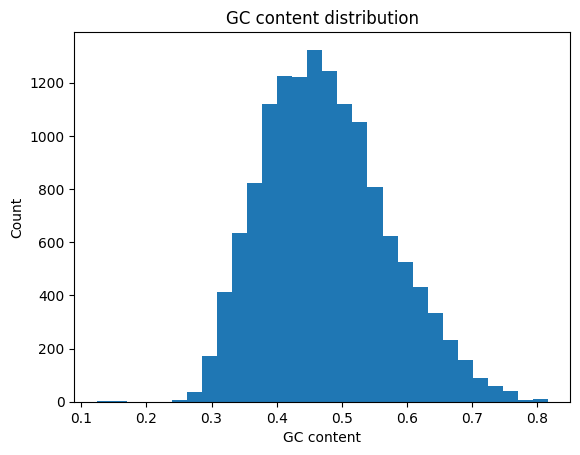

In [8]:
import matplotlib.pyplot as plt

plt.hist(test_df["gc"], bins=30)
plt.xlabel("GC content")
plt.ylabel("Count")
plt.title("GC content distribution")
plt.show()


In [ ]:
# 전체적으로 대칭적 분포, 평균과 비슷함
# GC 평균 48.6%로 인간 또는 포유류 게놈 평균 함량과 유사함
# 표준편차 0.095로 다양성이 큼
# 다양한 게놈 영역으로 프로모터, 엑손, 인트로 등이 섞여있을 수 있음
# GC min=0.0124, max=0.816으로 모델이 극단적인 시퀀스에서도 일반화할 수 있어야함
# GC stratified sampling이 성능 향상에 좋을 것 같음

In [9]:
# k-mer 분포 확인
from collections import Counter

def kmer_counts(seq, k=3):
    c = Counter()
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        c[kmer] += 1
    return c

k = 3
kmer_counter = Counter()

# 너무 오래 걸리지 않게, 앞의 200개 샘플만 사용해도 됨
for s in test_df["seq"].head(200):
    kmer_counter.update(kmer_counts(s, k=k))

# 가장 많이 나온 20개 k-mer 확인
print(f"Top 20 {k}-mers:")
for kmer, cnt in kmer_counter.most_common(20):
    print(kmer, cnt)


Top 20 3-mers:
AAA 5709
TTT 5576
CAG 4633
CTG 4434
AGA 4308
AGG 4203
CCA 4072
GAG 4005
TGG 3978
AAG 3977
TCT 3948
CCT 3902
GGG 3844
CTC 3805
AAT 3793
CCC 3767
TCA 3766
GGA 3757
GAA 3744
CTT 3729


In [ ]:
# 3-mer tokenization이 매우 자연스러움
# -> gLM이 BPE 기반이더라도, 자연적으로 3-mer 단위 생물학적 의미를 포함하고 있음

# 모델은 코딩 영역에서 변이 감지 민감도가 더 높을 가능성이 있음
# ->의미적 motif(CAG, CTG 등) 내 변이는 cosine distance 증가로 이어질 수 있음

# 비코딩 Poly-A/T 반복은 변이 민감도 낮은 baseline noise로 작용
# -> 임베딩 간 거리 비교 시 “거의 변하지 않는 구간”

# Fine-tuning 시 Masking 전략 차등 적용 가능
# ->Poly-A/T 영역보다 C/G-rich motif 영역에 mask 확률 ↑

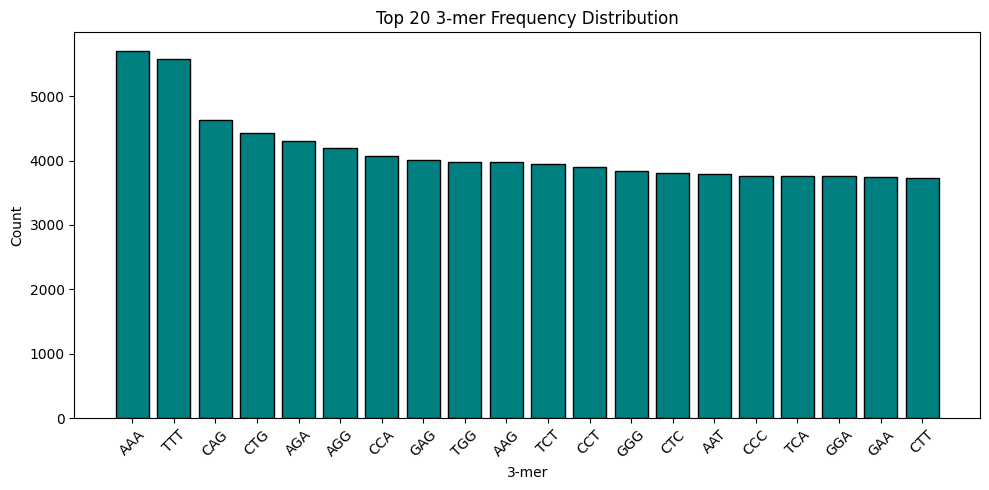

In [10]:
# 시각
import matplotlib.pyplot as plt

# 상위 20개 3-mer
top_kmers = list(kmer_counter.most_common(20))
kmers, counts = zip(*top_kmers)

plt.figure(figsize=(10,5))
plt.bar(kmers, counts, color='teal', edgecolor='black')
plt.xticks(rotation=45)
plt.title("Top 20 3-mer Frequency Distribution")
plt.xlabel("3-mer")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [11]:
# 파생변수 생성 및 점검
import numpy as np
from collections import Counter
from math import log2

# 1) GC content (이미 있다면 스킵해도 됨)
def gc_content(seq: str) -> float:
    seq = seq.upper()
    g = seq.count("G")
    c = seq.count("C")
    length = len(seq)
    return (g + c) / length if length > 0 else 0.0

# 2) 염기 조성 엔트로피 (서열 복잡도)
def seq_entropy(seq: str) -> float:
    counts = Counter(seq)
    total = len(seq)
    if total == 0:
        return 0.0
    probs = [v / total for v in counts.values()]
    return -sum(p * log2(p) for p in probs if p > 0)

# 3) 최장 연속 반복 염기 길이 (poly-A/T 등 반복 구조)
def longest_repeat(seq: str) -> int:
    if not seq:
        return 0
    max_len = 1
    cur_len = 1
    for i in range(1, len(seq)):
        if seq[i] == seq[i-1]:
            cur_len += 1
            max_len = max(max_len, cur_len)
        else:
            cur_len = 1
    return max_len

# 4) "CG" dinucleotide 빈도 (CpG island 관련)
def cg_count(seq: str) -> int:
    return seq.count("CG")

# 5) k-mer 다양도 (고유 3-mer 개수 / 전체 3-mer 개수)
def kmer_diversity(seq: str, k: int = 3) -> float:
    n = len(seq)
    if n < k:
        return 0.0
    kmers = {seq[i:i+k] for i in range(n - k + 1)}
    return len(kmers) / (n - k + 1)


In [12]:
# 만약 아직 gc를 안 구했다면 먼저 추가
if "gc" not in test_df.columns:
    test_df["gc"] = test_df["seq"].apply(gc_content)

# 나머지 파생변수 생성
test_df["entropy"]   = test_df["seq"].apply(seq_entropy)       # 염기 분포 복잡도
test_df["poly_len"]  = test_df["seq"].apply(longest_repeat)    # 최장 연속 동일 염기 길이
test_df["cg_count"]  = test_df["seq"].apply(cg_count)          # "CG" 등장 횟수
test_df["kmer_div"]  = test_df["seq"].apply(kmer_diversity)    # 3-mer 다양도 (0~1 사이)

test_df[["gc", "entropy", "poly_len", "cg_count", "kmer_div"]].head()


,gc,entropy,poly_len,cg_count,kmer_div
0,0.474609,1.997481,7,43,0.062622
1,0.636719,1.944158,7,38,0.062622
2,0.405273,1.970523,6,16,0.062622
3,0.513672,1.971744,4,15,0.062622
4,0.446289,1.990305,26,32,0.062622


In [13]:
test_df[["gc", "entropy", "poly_len", "cg_count", "kmer_div"]].describe()


,gc,entropy,poly_len,cg_count,kmer_div
count,13711.000000,13711.000000,13711.000000,13711.000000,13711.000000
mean,0.476192,1.964270,7.944278,28.204653,0.061979
std,0.095096,0.038955,4.066725,25.125128,0.001314
min,0.124023,1.261930,4.000000,0.000000,0.033268
25%,0.405273,1.950004,6.000000,10.000000,0.061644
50%,0.468750,1.977425,7.000000,19.000000,0.062622
75%,0.537109,1.991152,8.000000,40.000000,0.062622
max,0.816406,2.000000,42.000000,181.000000,0.062622


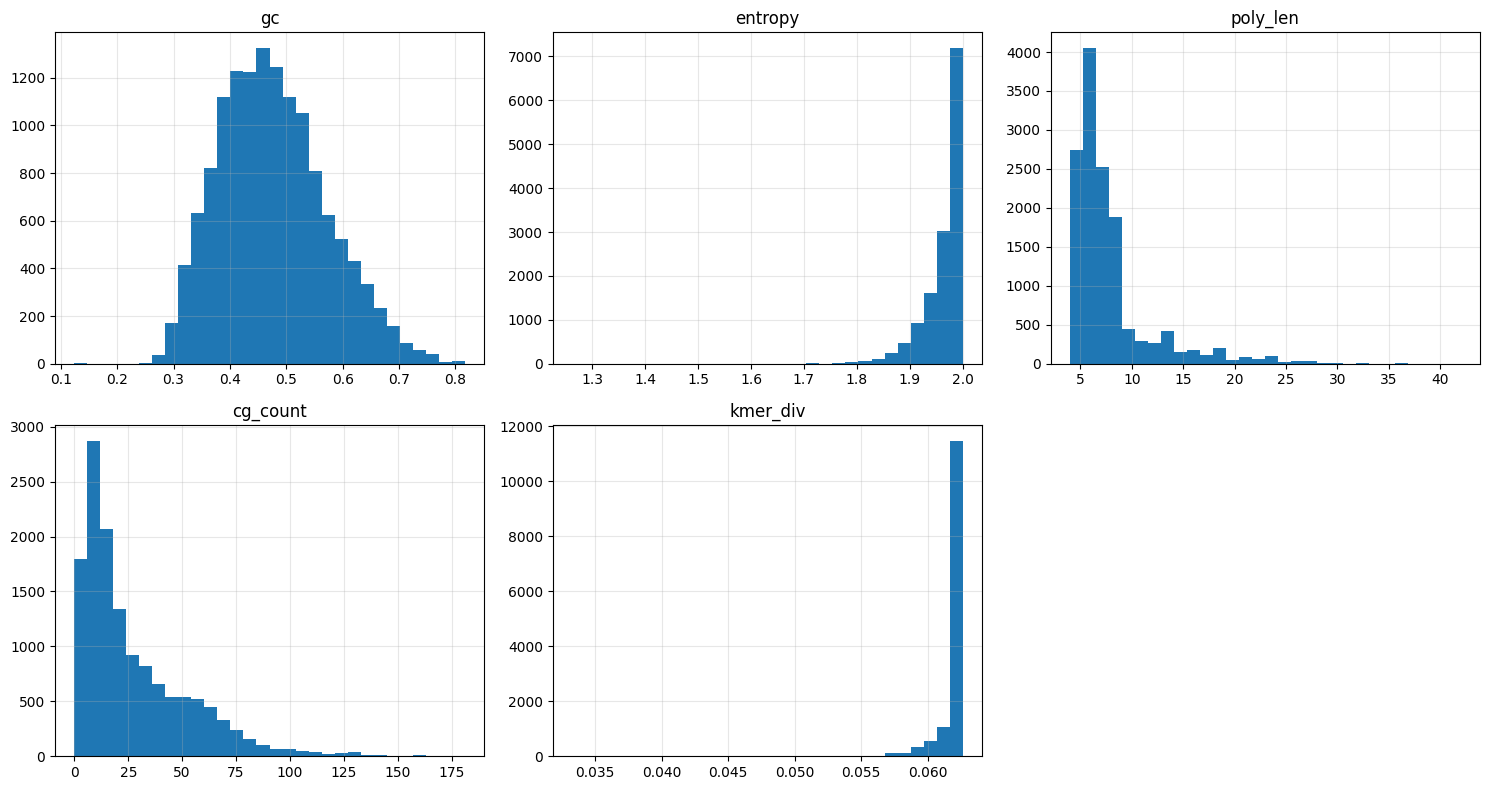

In [14]:
import matplotlib.pyplot as plt

features = ["gc", "entropy", "poly_len", "cg_count", "kmer_div"]

plt.figure(figsize=(15, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    plt.hist(test_df[col], bins=30)
    plt.title(col)
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# 1. GC 비율
# GC 비율의 다양성이 크므로, 모델은“GC-high 구간의 구조적 변이 감지 능력” vs “AT-rich 구간의 반복성 구분 능력”
# 모두 학습해야 함.

# 2. entropy
# 모델은 변이가 “균일한 서열 내에 발생했는가”, “반복 구간 내에 발생했는가”에 따라 민감도가 달라짐.
# 낮은 entropy 영역은 변이에 둔감할 가능성이 높음 → fine-tuning 시 entropy-based masking 조정 가능.

# 3. poly len(최장 반복 염기 길이)
# 긴 반복 영역은 모델의 변이 감지에 방해가 될 수 있음.
# fine-tuning 시 Poly-A/T 반복 구간은 학습 손실 가중치를 낮추거나 제외할 수도 있음.

# 4. CG 등장 횟수
# 변이 민감도 실험 시 “CG 빈도가 높은 영역”에서 cosine distance가 크게 변한다면
# → 모델이 CpG hotspot(변이 잘 일어나는 부위)을 인식하고 있다는 증거.
# 이 feature는 post-hoc 해석(모델 해석) 에 매우 유용함.

# 5. 3-mer 다양성
# tokenizer 수준에서 이미 정보가 충분하므로 추가적인 token engineering은 필요 없음.
# 단, 특정 서열(예: poly-A 영역)은 diversity가 낮을 수 있음 → 모델 해석 시 distance outlier로 감지 가능.

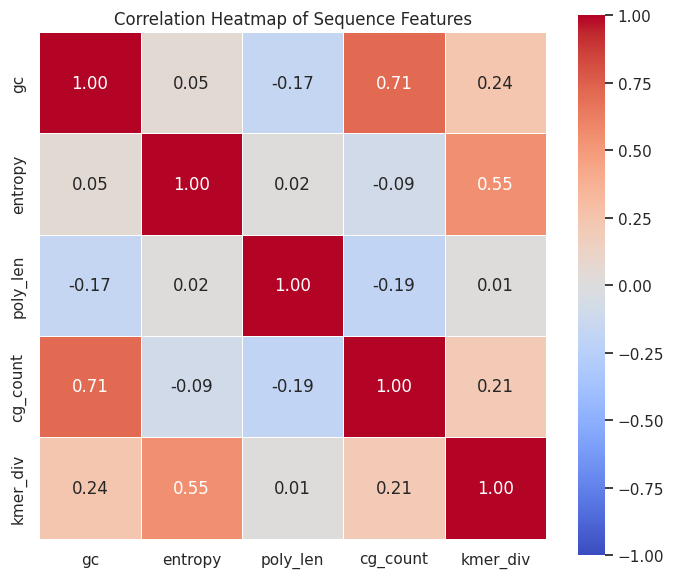

In [15]:
# feature 간 상관관계 heatmap + pairplot 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 노트북용 스타일(선택)
sns.set(style="whitegrid")

# 분석할 feature들
features = ["gc", "entropy", "poly_len", "cg_count", "kmer_div"]

# 상관계수 계산
corr = test_df[features].corr()

plt.figure(figsize=(7, 6))
sns.heatmap(
    corr,
    annot=True,        # 상관계수 숫자 표시
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Sequence Features")
plt.tight_layout()
plt.show()


(1000, 5)


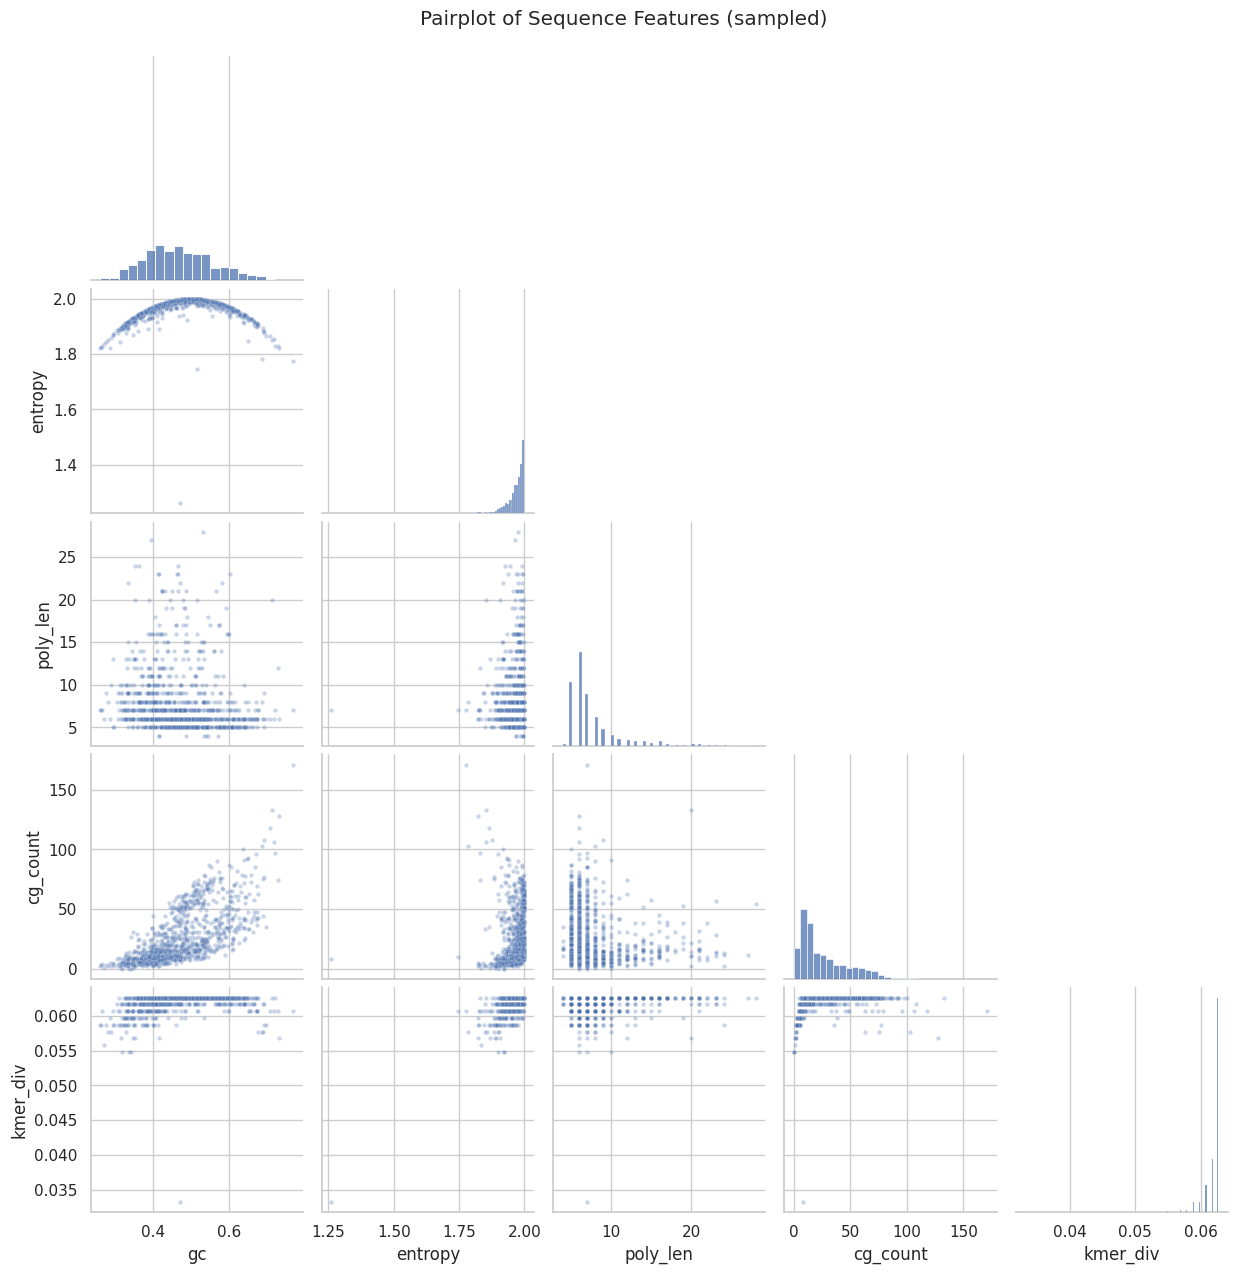

In [16]:
# pairplot용 샘플링 (1,000개 정도)
sample_n = 1000
sample_df = test_df[features].sample(n=sample_n, random_state=42)

print(sample_df.shape)

# pairplot 그리기
sns.pairplot(
    sample_df,
    corner=True,              # 위쪽 삼각형 생략
    diag_kind="hist",         # 대각선은 히스토그램
    plot_kws={"alpha": 0.3, "s": 10}  # 점 투명도/크기
)
plt.suptitle("Pairplot of Sequence Features (sampled)", y=1.02)
plt.show()


In [ ]:
# 분석전략
# 1. 구조탐색(DEA)
# 2. feature 기반 Grouping
# 3. 임베딩 해석 및 보정
# 4. 모델 확장
# 5. 평가, 시각화 강화

✅ 압축 해제 완료!
압축 풀린 파일 목록: ['sample_submission.csv', 'test.csv']
✅ test_df: (13711, 2)
✅ sub_df:  (13711, 769)
            ID                                                seq
0  TEST_000000  ATCATTTTTATTTTTTAGTTTTATGAGACGCTGCCTTGCTATGTCA...
1  TEST_000001  CGACGTCCCCGTAGCGGCCGAAGTCGAGGGGCAGCAGGCGATCGTG...
2  TEST_000002  GGTAGTAAGAAGGAAAATGACAGCATGGAAGCAGCAATACCAGTAA...
3  TEST_000003  CAGCGCATATACTCAGGGCCATGGTGGGTACTGTTCCCATGGCCAG...
4  TEST_000004  TTCATAATTGCTATCAGTCTATGGGCTAATATTTTATACATCAATG...
Sequence Length: count    13711.0
mean      1024.0
std          0.0
min       1024.0
25%       1024.0
50%       1024.0
75%       1024.0
max       1024.0
Name: seq_len, dtype: float64

📊 Feature describe:
                 gc       entropy      poly_len      cg_count      kmer_div
count  13711.000000  13711.000000  13711.000000  13711.000000  13711.000000
mean       0.476192      1.964270      7.944278     28.204653      0.061979
std        0.095096      0.038955      4.066725     25.125128  

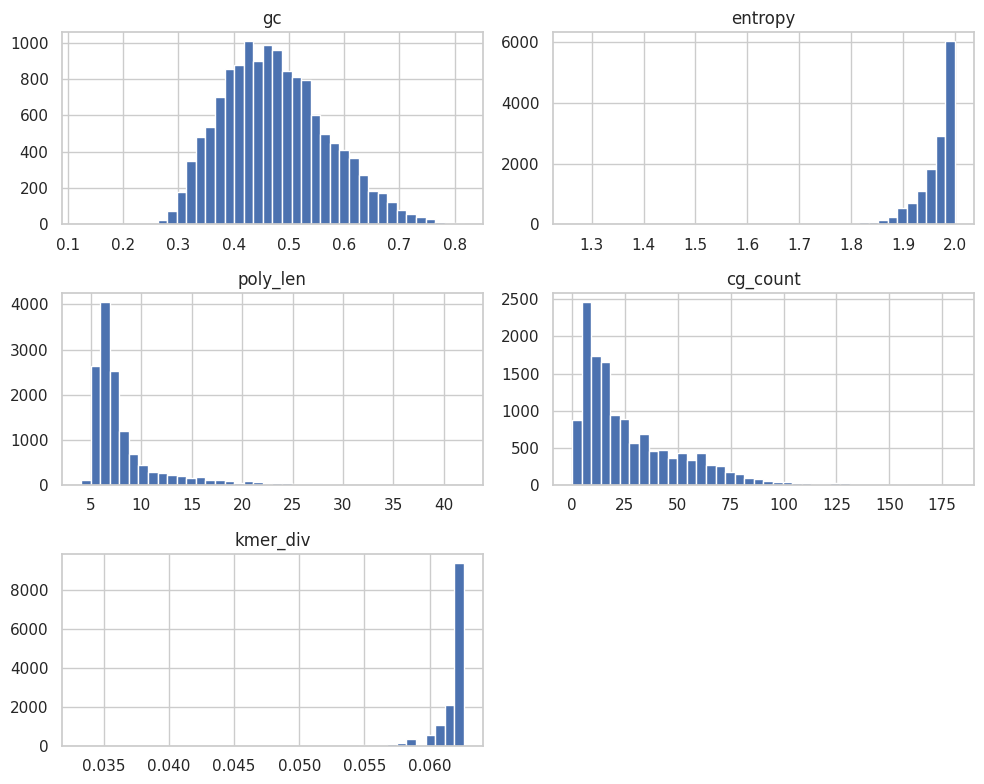

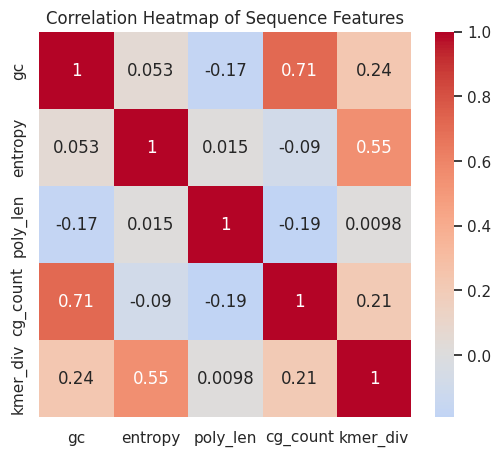


Cluster Feature Summary:
             gc  entropy  poly_len  cg_count  kmer_div
cluster                                               
0        0.6633   1.9047    6.3842   78.2926    0.0615
1        0.3649   1.9301    7.7098    6.9509    0.0606
2        0.4949   1.9829    6.5180   30.8520    0.0625
3        0.4564   1.9757   17.8207   18.4860    0.0623


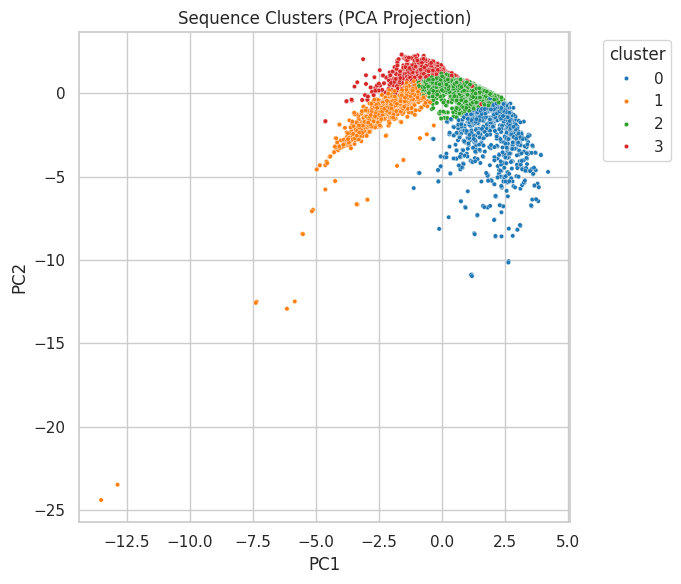

Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/101 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

esm_config.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species:
- esm_config.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_esm.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/nucleotide-transformer-v2-500m-multi-species:
- modeling_esm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

[get_embeddings] 20/429 batches done
[get_embeddings] 40/429 batches done
[get_embeddings] 60/429 batches done
[get_embeddings] 80/429 batches done
[get_embeddings] 100/429 batches done
[get_embeddings] 120/429 batches done
[get_embeddings] 140/429 batches done
[get_embeddings] 160/429 batches done
[get_embeddings] 180/429 batches done
[get_embeddings] 200/429 batches done
[get_embeddings] 220/429 batches done
[get_embeddings] 240/429 batches done
[get_embeddings] 260/429 batches done
[get_embeddings] 280/429 batches done
[get_embeddings] 300/429 batches done
[get_embeddings] 320/429 batches done
[get_embeddings] 340/429 batches done
[get_embeddings] 360/429 batches done
[get_embeddings] 380/429 batches done
[get_embeddings] 400/429 batches done
[get_embeddings] 420/429 batches done
✅ Embedding shape: torch.Size([13711, 1024])

Embedding Similarity by Cluster:
cluster
0    0.824046
1    0.881494
2    0.896030
3    0.887937
Name: embed_mean_sim, dtype: float32
Hybrid feature shape: (137

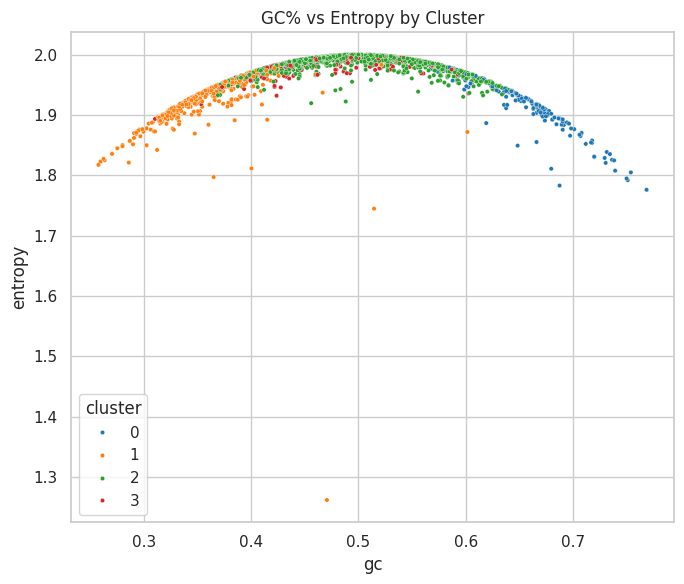

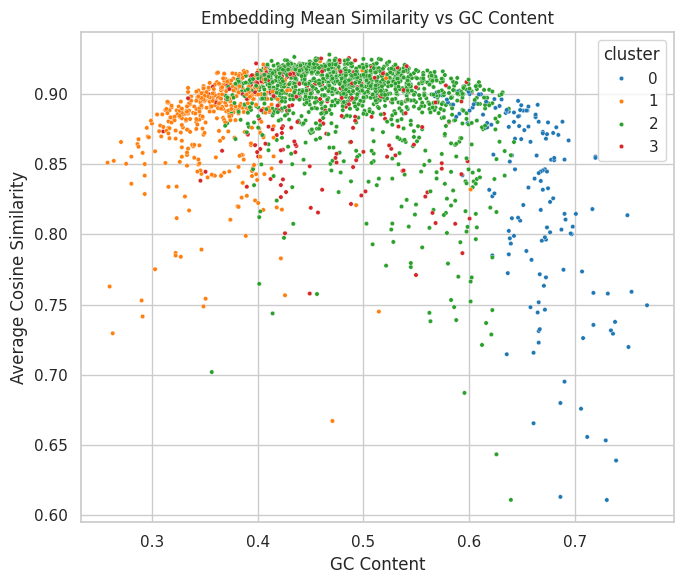

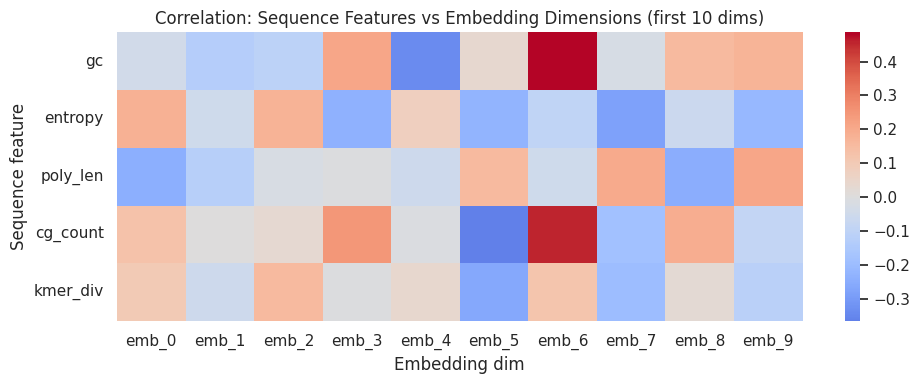

🎯 Pipeline Complete — EDA → Grouping → Embedding → Hybrid → Visualization


In [1]:
# ============================================
#  제2회 MAI 대회 통합 분석 파이프라인
#  Author: Hanbin
# ============================================

# 📦 0. 기본 세팅 & 압축 해제
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM

sns.set(style="whitegrid")

# ---------------------------------------------------
# 0️⃣ 압축 풀기 & 데이터 로드
# ---------------------------------------------------

# 구글 드라이브에 있는 zip 파일 경로
zip_path = "/open.zip"
extract_dir = "/content/open"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ 압축 해제 완료!")
print("압축 풀린 파일 목록:", os.listdir(extract_dir))

data_path = extract_dir  # test.csv, sample_submission.csv가 있는 폴더

test_df = pd.read_csv(os.path.join(data_path, "test.csv"))
sub_df  = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

print(f"✅ test_df: {test_df.shape}")
print(f"✅ sub_df:  {sub_df.shape}")
print(test_df.head())

# ---------------------------------------------------
# 1️⃣ 구조탐색(EDA)
# ---------------------------------------------------

# (1) 기본 통계
test_df["seq_len"] = test_df["seq"].str.len()
print("Sequence Length:", test_df["seq_len"].describe())

# (2) GC Content
def gc_content(seq: str) -> float:
    seq = seq.upper()
    g = seq.count("G")
    c = seq.count("C")
    return (g + c) / len(seq) if len(seq) > 0 else 0.0

test_df["gc"] = test_df["seq"].apply(gc_content)

# (3) Shannon Entropy
def seq_entropy(seq: str) -> float:
    counts = Counter(seq)
    total = len(seq)
    if total == 0:
        return 0.0
    probs = [c / total for c in counts.values()]
    return -sum(p * math.log2(p) for p in probs if p > 0)

test_df["entropy"] = test_df["seq"].apply(seq_entropy)

# (4) 반복 구간 (Polymer length)
def max_polymer_length(seq: str) -> int:
    if not seq:
        return 0
    current, max_len = 1, 1
    for i in range(1, len(seq)):
        if seq[i] == seq[i-1]:
            current += 1
            max_len = max(max_len, current)
        else:
            current = 1
    return max_len

test_df["poly_len"] = test_df["seq"].apply(max_polymer_length)

# (5) CpG count
test_df["cg_count"] = test_df["seq"].str.count("CG")

# (6) 3-mer 다양성
def kmer_diversity(seq: str, k: int = 3) -> float:
    n = len(seq)
    if n < k:
        return 0.0
    kmers = {seq[i:i+k] for i in range(n - k + 1)}
    return len(kmers) / (n - k + 1)

test_df["kmer_div"] = test_df["seq"].apply(kmer_diversity)

features = ["gc", "entropy", "poly_len", "cg_count", "kmer_div"]

print("\n📊 Feature describe:")
print(test_df[features].describe())

# (7) 요약 시각화 (히스토그램)
test_df[features].hist(bins=40, figsize=(10, 8))
plt.tight_layout()
plt.show()

# (8) 상관관계 Heatmap
corr = test_df[features].corr()
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Sequence Features")
plt.show()

# ---------------------------------------------------
# 2️⃣ Feature 기반 Grouping (KMeans + PCA)
# ---------------------------------------------------

scaler = StandardScaler()
X = scaler.fit_transform(test_df[features])

kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
test_df["cluster"] = kmeans.fit_predict(X)

# 군집별 평균
cluster_summary = test_df.groupby("cluster")[features].mean().round(4)
print("\nCluster Feature Summary:")
print(cluster_summary)

# PCA로 시각화
pca = PCA(n_components=2)
pca_vec = pca.fit_transform(X)

plt.figure(figsize=(7, 6))
sns.scatterplot(x=pca_vec[:, 0], y=pca_vec[:, 1],
                hue=test_df["cluster"], palette="tab10", s=10)
plt.title("Sequence Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 3️⃣ 임베딩 해석 및 보정
# ---------------------------------------------------

MODEL_ID = "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained(MODEL_ID, trust_remote_code=True)
model = model.to(DEVICE).eval()

class SeqDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.ids = df["ID"].tolist()
        self.seqs = df["seq"].tolist()
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        return {"ID": self.ids[idx], "seq": self.seqs[idx]}

def collate_fn(batch, tok=tokenizer, max_len=1024):
    seqs = [b["seq"] for b in batch]
    enc = tok.batch_encode_plus(
        seqs,
        padding="longest",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    return {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"]
    }

loader = DataLoader(
    SeqDataset(test_df),
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

@torch.no_grad()
def get_embeddings(model, loader, mode: str = "last_mean"):
    embs = []
    for step, batch in enumerate(loader):
        input_ids = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attention_mask"].to(DEVICE)

        outputs = model(
            input_ids,
            attention_mask=attn_mask,
            output_hidden_states=True,
        )
        hidden_states = outputs.hidden_states

        if mode == "last_mean":
            hs = hidden_states[-1]  # (B, L, H)
        elif mode == "last4_mean":
            hs = torch.stack(hidden_states[-4:], dim=0).mean(0)  # (B, L, H)
        else:
            raise ValueError("mode must be 'last_mean' or 'last4_mean'")

        mask_exp = attn_mask.unsqueeze(-1)          # (B, L, 1)
        summed = (hs * mask_exp).sum(dim=1)         # (B, H)
        counts = mask_exp.sum(dim=1).clamp(min=1)   # (B, 1)
        mean_emb = summed / counts                  # (B, H)

        embs.append(mean_emb.cpu())

        if (step + 1) % 20 == 0:
            print(f"[get_embeddings] {step+1}/{len(loader)} batches done")

    return torch.vstack(embs)

emb_tensor = get_embeddings(model, loader, mode="last_mean")
print("✅ Embedding shape:", emb_tensor.shape)

emb_np = emb_tensor.numpy()

# cosine 유사도 기반 cluster 평균 비교
similarity = cosine_similarity(emb_np)
avg_sim = np.mean(similarity, axis=1)
test_df["embed_mean_sim"] = avg_sim

embed_summary = test_df.groupby("cluster")["embed_mean_sim"].mean()
print("\nEmbedding Similarity by Cluster:")
print(embed_summary)

# ---------------------------------------------------
# 4️⃣ 모델 확장 (임베딩 + 생물학 feature 융합)
# ---------------------------------------------------

hybrid_features = np.hstack([emb_np, scaler.transform(test_df[features])])
print("Hybrid feature shape:", hybrid_features.shape)

# cluster별 대표 벡터
cluster_embs = []
for c in sorted(test_df["cluster"].unique()):
    cluster_embs.append(hybrid_features[test_df["cluster"] == c].mean(axis=0))
cluster_embs = np.vstack(cluster_embs)
print("Cluster Representative Embeddings shape:", cluster_embs.shape)

# ---------------------------------------------------
# 5️⃣ 평가 및 시각화 강화
# ---------------------------------------------------

# (1) Cluster별 GC–Entropy 관계
plt.figure(figsize=(7, 6))
sns.scatterplot(data=test_df.sample(n=2000, random_state=42),
                x="gc", y="entropy", hue="cluster", palette="tab10", s=10)
plt.title("GC% vs Entropy by Cluster")
plt.tight_layout()
plt.show()

# (2) Embedding Similarity vs GC%
plt.figure(figsize=(7, 6))
sns.scatterplot(data=test_df.sample(n=2000, random_state=42),
                x="gc", y="embed_mean_sim", hue="cluster", palette="tab10", s=10)
plt.title("Embedding Mean Similarity vs GC Content")
plt.xlabel("GC Content")
plt.ylabel("Average Cosine Similarity")
plt.tight_layout()
plt.show()

# (3) Correlation Heatmap of Embedding vs Feature (앞 10차원만)
embed_feature_df = pd.concat([
    test_df[features].reset_index(drop=True),
    pd.DataFrame(emb_np[:, :10], columns=[f"emb_{i}" for i in range(10)])
], axis=1)

corr_embed = embed_feature_df.corr().iloc[:len(features), len(features):]

plt.figure(figsize=(10, 4))
sns.heatmap(corr_embed, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation: Sequence Features vs Embedding Dimensions (first 10 dims)")
plt.xlabel("Embedding dim")
plt.ylabel("Sequence feature")
plt.tight_layout()
plt.show()

print("🎯 Pipeline Complete — EDA → Grouping → Embedding → Hybrid → Visualization")


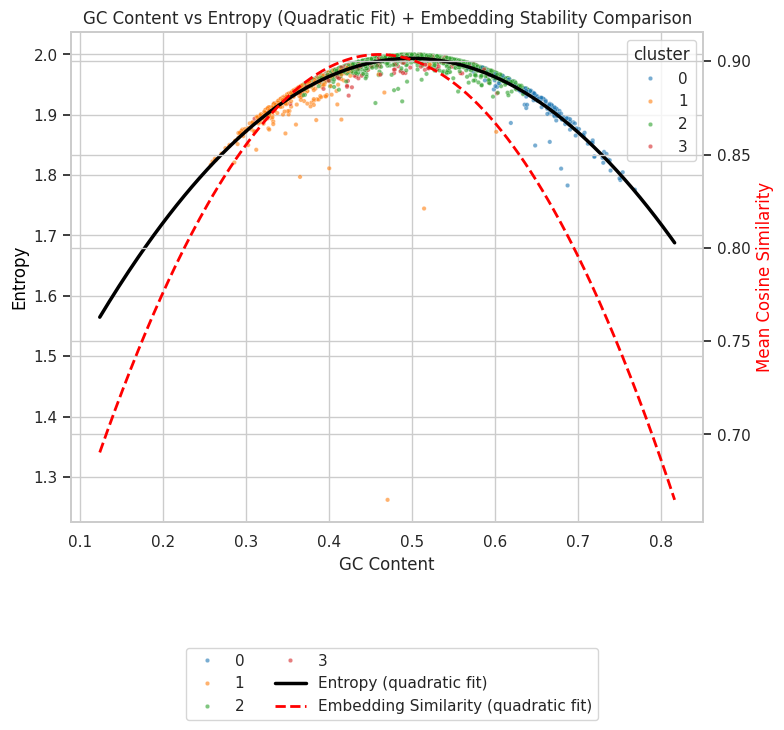

In [2]:
# GC vs Entropy 곡선의 2차 회귀 + 임베딩 mean similarity 비교 그래프
# ==============================================
# GC vs Entropy Quadratic Fit + Embedding Similarity Overlay
# ==============================================
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 데이터 준비
x = test_df["gc"].values.reshape(-1, 1)
y_entropy = test_df["entropy"].values
y_sim = test_df["embed_mean_sim"].values

# 다항회귀 (2차)
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)

# 회귀 모델 적합
model_entropy = LinearRegression().fit(x_poly, y_entropy)
model_sim = LinearRegression().fit(x_poly, y_sim)

# 예측 곡선
x_fit = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
x_fit_poly = poly.transform(x_fit)
y_entropy_pred = model_entropy.predict(x_fit_poly)
y_sim_pred = model_sim.predict(x_fit_poly)

# -------------------------------
# 시각화
# -------------------------------
fig, ax1 = plt.subplots(figsize=(8, 6))

# Entropy (왼쪽 y축)
sns.scatterplot(x="gc", y="entropy", data=test_df.sample(n=2000, random_state=42),
                hue="cluster", palette="tab10", s=10, alpha=0.6, ax=ax1)
ax1.plot(x_fit, y_entropy_pred, color="black", linewidth=2.5, label="Entropy (quadratic fit)")
ax1.set_xlabel("GC Content")
ax1.set_ylabel("Entropy", color="black")

# Embedding similarity (오른쪽 y축)
ax2 = ax1.twinx()
ax2.plot(x_fit, y_sim_pred, color="red", linewidth=2.0, linestyle="--", label="Embedding Similarity (quadratic fit)")
ax2.set_ylabel("Mean Cosine Similarity", color="red")

# 제목 및 범례
plt.title("GC Content vs Entropy (Quadratic Fit) + Embedding Stability Comparison")
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=2)
plt.tight_layout()
plt.show()


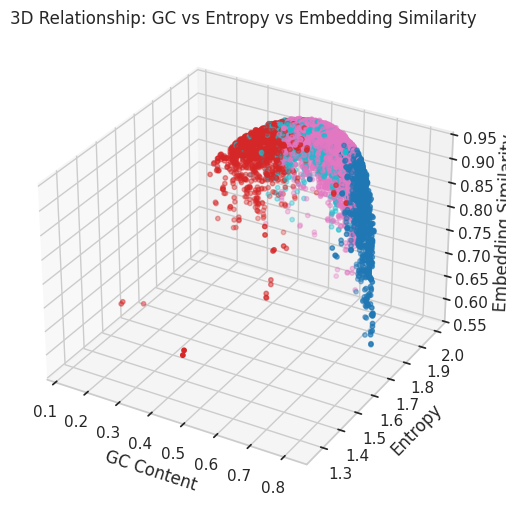

In [3]:
# 3D Surface Plot 시각화 (GC × Entropy × Similarity)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(test_df["gc"], test_df["entropy"], test_df["embed_mean_sim"],
            c=test_df["cluster"], cmap="tab10", s=10)
ax.set_xlabel("GC Content")
ax.set_ylabel("Entropy")
ax.set_zlabel("Embedding Similarity")
plt.title("3D Relationship: GC vs Entropy vs Embedding Similarity")
plt.show()


In [5]:
# ============================================
# 파생변수까지 만든 test_df / sub_df 이후에 실행하는 제출용 코드
# - gLM last-4-layer mean (또는 last_mean) + bio-feature concat
# ============================================

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sklearn.preprocessing import StandardScaler

# --------------------------
# 0. 환경 세팅 (이미 있어도 다시 해도 괜찮음)
# --------------------------
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Device:", DEVICE)

# test_df, sub_df는 이미 이전 셀에서 로드되어 있다고 가정
print("✅ Current test_df shape:", test_df.shape)
print("✅ Current sub_df shape :", sub_df.shape)

# --------------------------
# 1. 생물학 feature 컬럼 정리
#    (기본 5개 + 2차항 3개, 없으면 생성)
# --------------------------

# 기본 feature가 없다면 에러 방지 차원에서 한 번 체크
required_base = ["gc", "entropy", "poly_len", "cg_count", "kmer_div"]
missing = [c for c in required_base if c not in test_df.columns]
if missing:
    raise ValueError(f"다음 기본 feature가 test_df에 없습니다: {missing}")

# 2차항이 없으면 여기서 생성
if "gc_sq" not in test_df.columns:
    test_df["gc_sq"] = test_df["gc"] ** 2
if "entropy_sq" not in test_df.columns:
    test_df["entropy_sq"] = test_df["entropy"] ** 2
if "gc_entropy" not in test_df.columns:
    test_df["gc_entropy"] = test_df["gc"] * test_df["entropy"]

bio_cols = [
    "gc", "entropy", "poly_len", "cg_count", "kmer_div",
    "gc_sq", "entropy_sq", "gc_entropy",
]
print("✅ bio feature columns:", bio_cols)

# 표준화
scaler = StandardScaler()
bio_feat_scaled = scaler.fit_transform(test_df[bio_cols].values.astype(np.float32))
print("✅ bio feature shape:", bio_feat_scaled.shape)

# --------------------------
# 2. gLM 모델 로드
# --------------------------
MODEL_ID = "InstaDeepAI/nucleotide-transformer-v2-500m-multi-species"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained(MODEL_ID, trust_remote_code=True)
model = model.to(DEVICE).eval()
print("✅ gLM model loaded.")

# --------------------------
# 3. Dataset & Dataloader
# --------------------------
class SeqDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.ids = df["ID"].tolist()
        self.seqs = df["seq"].tolist()
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        return {"ID": self.ids[idx], "seq": self.seqs[idx]}

def collate_fn(batch, tok=tokenizer, max_len=1024):
    seqs = [b["seq"] for b in batch]
    enc = tok.batch_encode_plus(
        seqs,
        padding="longest",
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    return {
        "input_ids": enc["input_ids"],
        "attention_mask": enc["attention_mask"],
    }

BATCH_SIZE = 32  # GPU VRAM 보고 16/64로 조절 가능
loader = DataLoader(
    SeqDataset(test_df),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

# --------------------------
# 4. 임베딩 추출 (last4_mean 또는 last_mean 선택)
# --------------------------
@torch.no_grad()
def get_embeddings(model, loader, mode: str = "last4_mean"):
    all_embs = []
    for step, batch in enumerate(loader):
        input_ids = batch["input_ids"].to(DEVICE)
        attn_mask = batch["attention_mask"].to(DEVICE)

        outputs = model(
            input_ids,
            attention_mask=attn_mask,
            output_hidden_states=True,
        )
        hidden_states = outputs.hidden_states

        if mode == "last_mean":
            hs = hidden_states[-1]                          # (B, L, H)
        elif mode == "last4_mean":
            hs = torch.stack(hidden_states[-4:], dim=0).mean(0)  # (B, L, H)
        else:
            raise ValueError("mode must be 'last_mean' or 'last4_mean'")

        mask_exp = attn_mask.unsqueeze(-1)                 # (B, L, 1)
        summed = (hs * mask_exp).sum(dim=1)                # (B, H)
        counts = mask_exp.sum(dim=1).clamp(min=1)          # (B, 1)
        seq_emb = summed / counts                          # (B, H)

        all_embs.append(seq_emb.cpu())

        if (step + 1) % 20 == 0:
            print(f"[get_embeddings] {step+1}/{len(loader)} batches done")

    return torch.vstack(all_embs)

# 여기에서 mode를 바꿔가며 실험 가능 ("last_mean"이 리더보드 기준 제일 좋았던 전략)
EMB_MODE = "last4_mean"   # 또는 "last_mean"
print(f"✅ 임베딩 추출 중... (mode={EMB_MODE})")
emb_tensor = get_embeddings(model, loader, mode=EMB_MODE)
emb_tensor = emb_tensor.float()
N, H = emb_tensor.shape
print(f"✅ gLM embedding shape: {N} x {H}")

emb_np = emb_tensor.numpy()

# --------------------------
# 5. gLM 임베딩 + bio feature 결합
# --------------------------
alpha = 1.0  # bio-feature 스케일 조절 계수 (필요하면 0.5 등으로 조정)
bio_scaled = bio_feat_scaled * alpha

emb_hybrid = np.concatenate([emb_np, bio_scaled], axis=1)
N2, H2 = emb_hybrid.shape
print(f"✅ hybrid embedding shape: {N2} x {H2}")

if H2 > 2048:
    raise ValueError(f"최종 차원수 {H2}가 2048을 초과했습니다. bio feature 수를 줄이거나 alpha를 조정하세요.")

# --------------------------
# 6. 제출 파일 생성
# --------------------------
emb_cols = [f"emb_{i:04d}" for i in range(H2)]
emb_df = pd.DataFrame(emb_hybrid, columns=emb_cols)

submission = pd.concat([sub_df[["ID"]], emb_df], axis=1)
out_path = "/content/submission_gLM_hybrid.csv"
submission.to_csv(out_path, index=False)

print("✅ Saved submission:", out_path)
display(submission.head())


✅ Device: cuda
✅ Current test_df shape: (13711, 10)
✅ Current sub_df shape : (13711, 769)
✅ bio feature columns: ['gc', 'entropy', 'poly_len', 'cg_count', 'kmer_div', 'gc_sq', 'entropy_sq', 'gc_entropy']
✅ bio feature shape: (13711, 8)
✅ gLM model loaded.
✅ 임베딩 추출 중... (mode=last4_mean)
[get_embeddings] 20/429 batches done
[get_embeddings] 40/429 batches done
[get_embeddings] 60/429 batches done
[get_embeddings] 80/429 batches done
[get_embeddings] 100/429 batches done
[get_embeddings] 120/429 batches done
[get_embeddings] 140/429 batches done
[get_embeddings] 160/429 batches done
[get_embeddings] 180/429 batches done
[get_embeddings] 200/429 batches done
[get_embeddings] 220/429 batches done
[get_embeddings] 240/429 batches done
[get_embeddings] 260/429 batches done
[get_embeddings] 280/429 batches done
[get_embeddings] 300/429 batches done
[get_embeddings] 320/429 batches done
[get_embeddings] 340/429 batches done
[get_embeddings] 360/429 batches done
[get_embeddings] 380/429 batches

,ID,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,...,emb_1022,emb_1023,emb_1024,emb_1025,emb_1026,emb_1027,emb_1028,emb_1029,emb_1030,emb_1031
0,TEST_000000,1.990406,-2.078129,3.696502,-1.632918,-1.460600,-2.187175,0.330743,-23.261053,1.637030,...,-4.611496,7.321917,-0.016645,0.852572,-0.232205,0.588888,0.489701,-0.110986,0.874872,0.067468
1,TEST_000001,0.708142,1.498566,-0.531975,0.821033,-2.642278,0.077660,0.984824,-14.606645,-1.306441,...,-0.314149,1.714426,1.688111,-0.516303,-0.232205,0.389877,0.489701,1.784706,-0.538984,1.637276
2,TEST_000002,1.956719,-2.436271,3.461709,-1.574557,-0.488097,-0.697741,-0.377044,-22.779720,1.016242,...,-4.253492,6.997829,-0.745788,0.160523,-0.478112,-0.485773,0.489701,-0.752935,0.155302,-0.741771
3,TEST_000003,1.989385,-2.092269,2.752448,-2.083813,-1.793401,-0.632772,0.417739,-23.920620,-0.114858,...,-4.364894,6.568041,0.394139,0.191882,-0.969926,-0.525575,0.489701,0.295231,0.187697,0.418445
4,TEST_000004,-0.025585,-2.185939,3.016835,-2.156791,-0.827291,0.977913,-0.479970,-28.426811,-0.547479,...,-3.341003,4.589850,-0.314464,0.668353,4.440030,0.151063,0.489701,-0.385413,0.682373,-0.256243
